Epoch 10/200 | D loss: 0.5316 | G loss: 0.8775
Epoch 20/200 | D loss: 0.5950 | G loss: 0.7681
Epoch 30/200 | D loss: 0.6071 | G loss: 0.8155
Epoch 40/200 | D loss: 0.6655 | G loss: 0.6823
Epoch 50/200 | D loss: 0.6203 | G loss: 0.7742
Epoch 60/200 | D loss: 0.5791 | G loss: 0.7703
Epoch 70/200 | D loss: 0.6332 | G loss: 0.8303
Epoch 80/200 | D loss: 0.6162 | G loss: 0.7194
Epoch 90/200 | D loss: 0.6071 | G loss: 0.8837
Epoch 100/200 | D loss: 0.6565 | G loss: 0.8070
Epoch 110/200 | D loss: 0.6426 | G loss: 0.7468
Epoch 120/200 | D loss: 0.6493 | G loss: 0.6658
Epoch 130/200 | D loss: 0.5891 | G loss: 0.8886
Epoch 140/200 | D loss: 0.5991 | G loss: 0.7726
Epoch 150/200 | D loss: 0.7644 | G loss: 0.6132
Epoch 160/200 | D loss: 0.6879 | G loss: 0.7456
Epoch 170/200 | D loss: 0.7300 | G loss: 0.7237
Epoch 180/200 | D loss: 0.6674 | G loss: 0.7559
Epoch 190/200 | D loss: 0.5890 | G loss: 0.7031
Epoch 200/200 | D loss: 0.6953 | G loss: 0.6931


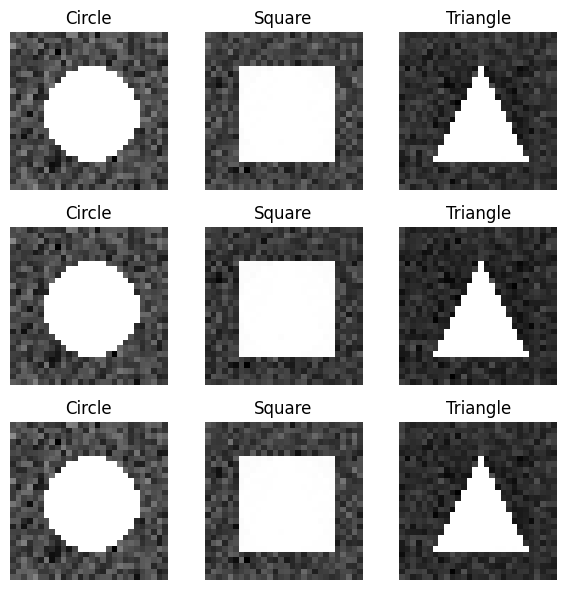

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import random

# Constants
image_size = 28
num_classes = 3
batch_size = 32
latent_dim = 100
num_epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utility: Create an image of a shape based on a label
def create_shape_image(label):
    img = Image.new('L', (image_size, image_size), color=0)
    draw = ImageDraw.Draw(img)
    if label == 0:  # Circle
        draw.ellipse([6, 6, 22, 22], fill=255)
    elif label == 1:  # Square
        draw.rectangle([6, 6, 22, 22], fill=255)
    elif label == 2:  # Triangle
        draw.polygon([14, 6, 6, 22, 22, 22], fill=255)
    return transforms.ToTensor()(img)

# Custom dataset
class ShapeDataset(Dataset):
    def __init__(self, length=1000):
        self.length = length
        self.data = []
        for _ in range(length):
            label = random.randint(0, 2)
            image = create_shape_image(label)
            self.data.append((image, label))

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        image, label = self.data[idx]
        return image, label

dataset = ShapeDataset()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, 50)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + 50, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, image_size * image_size),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embedding = self.label_emb(labels)
        x = torch.cat([noise, label_embedding], dim=1)
        img = self.model(x)
        return img.view(img.size(0), 1, image_size, image_size)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, 50)
        self.model = nn.Sequential(
            nn.Linear(image_size * image_size + 50, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_embedding = self.label_emb(labels)
        x = torch.cat([img.view(img.size(0), -1), label_embedding], dim=1)
        validity = self.model(x)
        return validity

generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

adversarial_loss = nn.BCELoss()

# Training loop
for epoch in range(num_epochs):
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        valid = torch.ones(imgs.size(0), 1).to(device)
        fake = torch.zeros(imgs.size(0), 1).to(device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (imgs.size(0),)).to(device)
        gen_imgs = generator(z, gen_labels)
        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(imgs, labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | D loss: {d_loss.item():.4f} | G loss: {g_loss.item():.4f}")

# Generate samples after training
def show_generated_shapes():
    z = torch.randn(9, latent_dim).to(device)
    labels = torch.tensor([0, 1, 2] * 3).to(device)  # circle, square, triangle
    gen_imgs = generator(z, labels).detach().cpu()

    fig, axs = plt.subplots(3, 3, figsize=(6, 6))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(gen_imgs[i][0], cmap='gray')
        ax.set_title(["Circle", "Square", "Triangle"][labels[i]])
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_generated_shapes()